# Partie 1: Classification de Documents

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Chargement des Données

In [ ]:
# Données d'entrainement
train_data_complete = pd.read_csv("../data/allocine_genres_train.csv", sep=",")
train_data = train_data_complete[["titre", "synopsis", "genre"]]

# Données de test/validation
test_data_complete = pd.read_csv("../data/allocine_genres_test.csv", sep=",")
trest_data = test_data_complete[["titre", "synopsis", "genre"]]

## Analyse des Données

### Analyse Générale

In [ ]:
train_data_complete.head(3)

In [ ]:
train_data_complete.tail(3)

In [ ]:
train_data_complete[["annee_prod", "annee_sortie", "duree", "nb_critiques_presse", "nb_critiques_spectateurs", "nb_notes_spectateurs", "note_presse", "note_spectateurs"]].describe()

In [ ]:
train_data_complete[["annee_prod", "annee_sortie", "duree", "nb_critiques_presse", "nb_critiques_spectateurs", "nb_notes_spectateurs", "note_presse", "note_spectateurs"]].hist(figsize=(12, 12))

In [ ]:
train_data_complete.info()

Il y a un total de 2875 entrées dans les données d'entrainement.

In [ ]:
train_data_complete.isna().sum()

Aucune valeur de *genre* n'est manquante. Etant donné que l'attribut *genre* sera utilisé comme label, nous pouvons utiliser toutes les entrées dans les données d'entrainement.

### Analyse des Données Utiles

On restreint les données aux attributs que nous utiliserons par la suite.

In [ ]:
# train_data = train_data_complete[["titre", "synopsis", "genre"]] (voir section "Chargement des Données")

In [ ]:
train_data.head(3)

In [ ]:
train_data.info()

In [ ]:
train_data.describe()

In [ ]:
train_data.isna().sum()

On remarque que tous les genres n'ont pas la même probabilité dans le jeu de donnée.

In [33]:
# train_data["genre"].hist(by=train_data["genre"
train_data["genre"].value_counts()

drame              501
comédie            483
romance            443
policier           331
horreur            299
science fiction    298
biopic             191
documentaire       167
historique         162
Name: genre, dtype: int64

## Pré-Traitement des Données

Comme vu précédemment, les paramètres que nous souhaitons utiliser (*titre*, *synopsis*, *genre*) ne comportent pas de valeurs manquantes donc nous n'avons pas besoin d'éliminer d'individus des données d'entrainement.

Nous remarquons aussi que les données sont déjà tokénisées. Tous les tokens sont séparés par des espaces.

Cependant, nous pouvons utiliser un transformer pour obtenir des informations statistiques concernant le *synopsis*.

**Remarque:** On normalise ces informations statistiques afin qu'elles aient toutes le même poids lors de la classification.

In [17]:
import string
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.fr.stop_words import STOP_WORDS as en_stop

from sklearn.feature_extraction.text import TfidfVectorizer

def transform_into_token_list(synopsis):
    return synopsis.split(" ")

nltk_stopwords_synopsis = list(fr_stop) + list(string.punctuation)
nltk_stopwords_titre = list(fr_stop) + list(en_stop) + list(string.punctuation)


titre_vectorizer = TfidfVectorizer(tokenizer=transform_into_token_list, 
                                  lowercase=True, 
                                  stop_words=nltk_stopwords_titre, 
                                  min_df=0.01)

# Objet TfidfVectorizer
synopsis_vectorizer = TfidfVectorizer(tokenizer=transform_into_token_list, 
                                      lowercase=True, 
                                      stop_words=nltk_stopwords_synopsis, 
                                      min_df=0.01)

['de', 'également', 'aura', 'sera', 'plutot', 'j’', 'autres', 'durant', 'notamment', 'son', 'différentes', 'onze', 'très', 'pourrais', 'sinon', "n'", 'abord', 'importe', 'quatre-vingt', 'tres', 'moi-meme', 'certains', 'suivre', 'nôtres', 'bas', 'ait', 'leur', 'voici', 'retour', 'aux', 'selon', 'd’', 'â', 'duquel', 'quelles', 'quant', 'quoi', "t'", 'cinq', 'treize', 'des', 'telles', 'ai', 'tant', 'ceux-ci', 'celle-ci', 'comment', 'deuxième', 'différent', 'es', 'eux-mêmes', 'seraient', 'je', 'celles-ci', 'enfin', 'elle', 'sauf', 'doivent', 'ne', 'lui-meme', 'ouias', 'avait', 'houp', 'ouverts', 'quiconque', 'miennes', 'revoici', 'revoila', 'y', 'font', 'moins', 'directement', 'qu’', 'soi-même', "m'", 'sont', 'attendu', 'hormis', "c'", 'possible', 'dejà', 'delà', 'differents', 'toi-même', 'moi-même', 'depuis', 'après', 'ès', 'semble', 'ça', 'semblable', 'cet', 'a', 'moi', 'allons', 'quatre', 'vas', 'suffisant', 'nombreuses', 'sans', 'revoilà', 'plutôt', 'eh', 'hé', 'certain', 'un', 'suivan

Certains stop words nous semblent important en tant qu'humain...

In [18]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

# Source: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer.html
def text_stats(descriptions):
    return [{"length": len(text), "num_sentences": text.count(".")} for text in descriptions]

text_stats_transformer = FunctionTransformer(text_stats)
text_stats_vectorizer = DictVectorizer(sparse=False)

res_dict = text_stats_transformer.transform(train_data.synopsis.head())
res_stats = text_stats_vectorizer.fit_transform(res_dict)
print("Input descriptions")
print(train_data.synopsis.head())
print("Output statistics")
stats = pd.DataFrame(res_stats, columns=text_stats_vectorizer.get_feature_names())
print(stats)

min_max_scaler = MinMaxScaler()
scaled_stats = min_max_scaler.fit_transform(res_stats)

print("Before MinMax scaling")
print(res_stats)
print("After MinMax scaling")
print(scaled_stats)

Input descriptions
0    En visite à Istanbul , le célèbre détective be...
1    Un jeune homme d' origine modeste est accusé d...
2    Lorsque Marie-Laure , mère de quatre jeunes en...
3    Un vagabond s’ éprend d’ une belle et jeune ve...
4    L' histoire vraie de Carl Brashear , premier A...
Name: synopsis, dtype: object
Output statistics
   length  num_sentences
0   677.0            4.0
1   460.0            4.0
2   560.0            4.0
3   233.0            4.0
4   340.0            2.0
Before MinMax scaling
[[677.   4.]
 [460.   4.]
 [560.   4.]
 [233.   4.]
 [340.   2.]]
After MinMax scaling
[[1.         1.        ]
 [0.51126126 1.        ]
 [0.73648649 1.        ]
 [0.         1.        ]
 [0.24099099 0.        ]]


/home/fabien/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


On peut créer une *Pipeline* qui effectue l'ensemble des transformation sur le jeu de données.

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

column_trans = ColumnTransformer(
    [
        # Titre: tf-idf
        ("titre_tfidf", titre_vectorizer, "titre"),
        # Synopsis: tf-idf
        ("synopsis_tfidf", synopsis_vectorizer, "synopsis"),
        # Synopsis: statistiques
        (
            "synopsis_stats",
            Pipeline(
                [
                    ("text_stats", text_stats_transformer),
                    ("vect", text_stats_vectorizer),
                    ("scaling", min_max_scaler)
                ]
            ), 
            "synopsis"
        )
    ],
    # Others
    remainder="passthrough"
)

In [21]:
column_trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('titre_tfidf',
                                 TfidfVectorizer(min_df=0.01,
                                                 stop_words=['de', 'également',
                                                             'aura', 'sera',
                                                             'plutot', 'j’',
                                                             'autres', 'durant',
                                                             'notamment', 'son',
                                                             'différentes',
                                                             'onze', 'très',
                                                             'pourrais',
                                                             'sinon', "n'",
                                                             'abord', 'importe',
                                                             'quatre

## Prediction de Genre

### Création des Jeux d'Entrainement et de Test

Afin de ne pas biaiser le résultat de nos recherches nous n'utiliserons le fichier *allocine_genres_test.csv* uniquement lorsque nous aurons définitivement choisit le classifier. Nous n'utiliserons donc pas *test_data_complete* et *test_data* dans cette section.

Afin de tester et évaluer différents algorithmes nous devons donc créer des jeux de données d'entrainement et de test issus des données d'entrainement (*train_data*). Pour cela nous utilisons la fonction *train_test_split* de la librairie **scikit-learn** en choisissant 20% des données pour créer le jeu de test en prenant soin de mélanger les données (cela perment d'éviter tout biais d'apprentissage: entrainer le classifier unioquement sur les films du XXème siècle).

Nous obtenons donc 4 jeux de données:
- X_train: Titre et synopsis pour entrainement  
- y_train: Genre pour entrainement (label)  
- X_test: Titre et synopsis pour test  
- y_test: Genre pour test (label)  

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data[["titre", "synopsis"]],
                                                    train_data[["genre"]],
                                                    test_size=0.2,
                                                    random_state=12, # Random seed for shuffle
                                                    shuffle=True)

### Apprentissage

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# Pipeline pré-traitement et apprentissage
classifier_pipeline = make_pipeline(
    # Préparation des données pour l'apprentissage
    column_trans,
    # Algorithme d'apprentissage
    LogisticRegression()
)

In [28]:
# Apprentissage avec les données d'entraînement
classifier_pipeline.fit(X_train, y_train.to_numpy())

/home/fabien/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('titre_tfidf',
                                                  TfidfVectorizer(min_df=0.01,
                                                                  stop_words=['de',
                                                                              'également',
                                                                              'aura',
                                                                              'sera',
                                                                              'plutot',
                                                                              'j’',
                                                                              'autres',
                                                                              'durant',
                                                               

In [29]:
from sklearn.metrics import classification_report

y_pred = classifier_pipeline.predict(X_test)
print("Classification report:\n\n{}".format(classification_report(y_test, y_pred)))

Classification report:

                 precision    recall  f1-score   support

         biopic       0.64      0.16      0.26        43
        comédie       0.42      0.53      0.47       100
   documentaire       0.78      0.17      0.29        40
          drame       0.38      0.47      0.42       112
     historique       0.36      0.19      0.24        27
        horreur       0.47      0.36      0.40        59
       policier       0.52      0.56      0.54        57
        romance       0.34      0.51      0.41        78
science fiction       0.54      0.49      0.51        59

       accuracy                           0.43       575
      macro avg       0.49      0.38      0.39       575
   weighted avg       0.47      0.43      0.42       575



In [ ]:
from sklearn.metrics import confusion_matrix

# Liste des labels (classes) se trouvant dans les données de test
labels = np.unique(y_test)
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=labels)
# Matrice de confusion sous forme de DataFrame
confusion_df = pd.DataFrame(cm, index=labels, columns=labels)
print('confusion matrix\n')
print('(row=expected, col=predicted)')
confusion_df.head(n=15)

confusion matrix

(row=expected, col=predicted)


,biopic,comédie,documentaire,drame,historique,horreur,policier,romance,science fiction
biopic,7,5,1,8,3,3,4,8,4
comédie,0,53,0,19,2,2,5,18,1
documentaire,1,9,7,9,1,1,1,5,6
drame,1,17,1,53,2,6,6,24,2
historique,2,2,0,7,5,1,1,5,4
horreur,0,8,0,10,1,21,6,7,6
policier,0,9,0,7,0,5,32,2,2
romance,0,16,0,18,0,1,3,40,0
science fiction,0,6,0,8,0,5,3,8,29


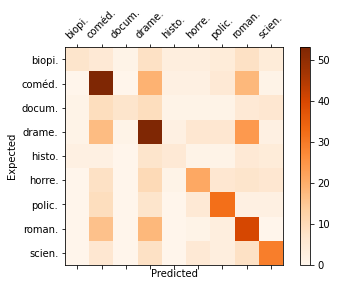

In [32]:
fig = plt.figure() 
ax = fig.add_subplot(111) 
cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Oranges) 
fig.colorbar(cax) 
tick_marks = np.arange(len(labels))
labels_for_fig = [l[0:5]+'.' for l in labels]
plt.xticks(tick_marks, labels_for_fig, rotation=45)
plt.yticks(tick_marks, labels_for_fig) 
plt.xlabel('Predicted') 
plt.ylabel('Expected') 
plt.show()